In [15]:
import pandas as pd
import seaborn as sns

In [2]:
!pwd

/Users/jackhousego/code/DuplexFuture/email_prep/email_classification_nlp_0722/notebooks


In [7]:
train_path = "../raw_data/SMS_train.csv"
test_path = "../raw_data/SMS_test.csv"

train = pd.read_csv(train_path, encoding = 'latin-1')
test = pd.read_csv(test_path, encoding = 'latin-1')
train.head()

,S. No.,Message_body,Label
0,1,Rofl. Its true to its name,Non-Spam
1,2,The guy did some bitching but I acted like i'd...,Non-Spam
2,3,"Pity, * was in mood for that. So...any other s...",Non-Spam
3,4,Will ü b going to esplanade fr home?,Non-Spam
4,5,This is the 2nd time we have tried 2 contact u...,Spam


In [9]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

Train shape:  (957, 3)
Test shape:  (125, 3)


In [14]:
print("Train is null count per column: \n", train.isnull().sum())
print("Test is null count per column: \n", test.isnull().sum())

Train is null count per column: 
 S. No.          0
Message_body    0
Label           0
dtype: int64
Test is null count per column: 
 S. No.          0
Message_body    0
Label           0
dtype: int64


<AxesSubplot:xlabel='Label', ylabel='count'>

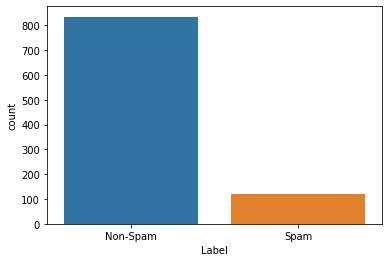

In [18]:
sns.countplot(train['Label'])

In [24]:
train['Label'].value_counts()

Non-Spam    835
Spam        122
Name: Label, dtype: int64

/Users/jackhousego/.pyenv/versions/3.8.13/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


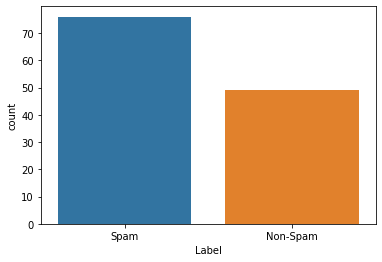

In [21]:
sns.countplot(test['Label']);

In [27]:
# impute target variable 

target_dict = {'Non-Spam': 0, 'Spam': 1}
train['Label'] = train['Label'].map(target_dict)
test['Label'] = test['Label'].map(target_dict)

In [31]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

In [30]:
import re

In [38]:


lemma = WordNetLemmatizer()
swords = stopwords.words("english")

def clean_data(df):
    cleaned_data = []
    for text in df['Message_body']:
        # Remove links from messages
        text = re.sub("r/http\S+", '', text)

        # Cleaning everything apart from alphabetical and numerical characters 
        text = re.sub("[^a-zA-Z0-9]", " ", text)

        # Tokenizing and Lemmatizing
        text = nltk.word_tokenize(text.lower())
        text = [lemma.lemmatize(word) for word in text]

        # removing stop words
        text = [word for word in text if word not in swords]

        # joining 
        text = " ".join(text)

        cleaned_data.append(text)   
    return cleaned_data

In [40]:
cleaned_train = clean_data(train)
cleaned_test = clean_data(test)

In [41]:
import numpy as np

In [42]:
vocab_max_size = len(set(cleaned_train))
print(f'Vocab size: {vocab_max_size}')

max_sentence = np.max([len(i) for i in cleaned_train])
print(f'Max Sentence size: {max_sentence}')

Vocab size: 942
Max Sentence size: 339


In [46]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [47]:
voc_size = 5000 # this can be altered

# convert text to index with padding 

one_hot_train = [one_hot(words, voc_size) for words in cleaned_train]
one_hot_test = [one_hot(words, voc_size) for words in cleaned_test]

max_sentence_length = 30 # this can be altered 

pad_train = pad_sequences(one_hot_train, padding='pre', maxlen=max_sentence_length)
pad_test = pad_sequences(one_hot_test, padding='pre', maxlen=max_sentence_length)

print("Pad Train shape: ", pad_train.shape)
print(f"Pad Test shape: {pad_test.shape}")

Pad Train shape:  (957, 30)
Pad Test shape: (125, 30)


In [49]:
pad_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0, 3004,  412, 4714,  979, 1445,
       2973, 4348,  311, 4860, 4982,  318, 2924, 2376], dtype=int32)

In [50]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

In [54]:
from tensorflow.keras.metrics import Recall

In [55]:
# creating a model:

embedding_vector_features = 100
model = Sequential()

model.add(Embedding(voc_size, embedding_vector_features, input_length=max_sentence_length))
model.add(Dropout(0.5))
model.add(LSTM(200))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy', Recall()])

In [57]:
# input needs to be an array:

X_train = np.array(pad_train)
X_test = np.array(pad_test)

y_train = np.array(train['Label'])
y_test = np.array(test['Label'])

In [58]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.2448 - accuracy: 0.8997 - recall: 0.2131  

2022-07-26 14:02:22.996740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-26 14:02:23.094591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 74ms/step - loss: 0.2448 - accuracy: 0.8997 - recall: 0.2131 - val_loss: 0.4945 - val_accuracy: 0.8000 - val_recall: 0.6711
Epoch 2/100
15/15 [==============================] - 1s 43ms/step - loss: 0.1568 - accuracy: 0.9624 - recall: 0.7951 - val_loss: 0.3117 - val_accuracy: 0.9200 - val_recall: 0.9342
Epoch 3/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0998 - accuracy: 0.9781 - recall: 0.8361 - val_loss: 0.2793 - val_accuracy: 0.8800 - val_recall: 0.8026
Epoch 4/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0423 - accuracy: 0.9916 - recall: 0.9508 - val_loss: 0.1682 - val_accuracy: 0.9440 - val_recall: 0.9079
Epoch 5/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0271 - accuracy: 0.9927 - recall: 0.9508 - val_loss: 0.2104 - val_accuracy: 0.9280 - val_recall: 0.8816
Epoch 6/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0154 - accuracy: 0.9969 - recall: 0.

Epoch 46/100
15/15 [==============================] - 1s 37ms/step - loss: 3.8828e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4382 - val_accuracy: 0.9120 - val_recall: 0.8553
Epoch 47/100
15/15 [==============================] - 1s 36ms/step - loss: 3.0354e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4453 - val_accuracy: 0.9120 - val_recall: 0.8553
Epoch 48/100
15/15 [==============================] - 1s 36ms/step - loss: 3.6116e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4401 - val_accuracy: 0.9120 - val_recall: 0.8553
Epoch 49/100
15/15 [==============================] - 1s 35ms/step - loss: 3.6540e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4301 - val_accuracy: 0.9120 - val_recall: 0.8553
Epoch 50/100
15/15 [==============================] - 1s 35ms/step - loss: 3.2912e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4264 - val_accuracy: 0.9200 - val_recall: 0.8684
Epoch 51/100
15/15 [==============================] - 1s 35ms/step - loss: 

15/15 [==============================] - 1s 35ms/step - loss: 9.2591e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4217 - val_accuracy: 0.9280 - val_recall: 0.8947
Epoch 91/100
15/15 [==============================] - 1s 36ms/step - loss: 8.6474e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4261 - val_accuracy: 0.9280 - val_recall: 0.8947
Epoch 92/100
15/15 [==============================] - 1s 35ms/step - loss: 1.1018e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4266 - val_accuracy: 0.9280 - val_recall: 0.8947
Epoch 93/100
15/15 [==============================] - 1s 36ms/step - loss: 1.5120e-05 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4155 - val_accuracy: 0.9360 - val_recall: 0.9079
Epoch 94/100
15/15 [==============================] - 1s 34ms/step - loss: 8.9300e-06 - accuracy: 1.0000 - recall: 1.0000 - val_loss: 0.4110 - val_accuracy: 0.9360 - val_recall: 0.9079
Epoch 95/100
15/15 [==============================] - 1s 36ms/step - loss: 9.4888e-06 - 